In [1]:
import time

import torch
import torch.nn as nn
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import numpy as np

from stabnode.node import FTerm, GTerm, set_global_seed, StabNODE
from data.hysteresis import simulate_steady_state
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
seed = 1234
set_global_seed(seed = seed)

# Simple hysteresis learning

In [3]:
lam_start = -1 
lam_end = 1

n_points = 250

lam_increase = np.linspace(lam_start,lam_end, n_points)
lam_decrease = np.linspace(lam_end, lam_start, n_points)

In [4]:
x0=-1

simulate_time = (0.,50.)

x_increase = simulate_steady_state(lam_increase, x0, simulate_time)
x_decrease = simulate_steady_state(lam_decrease, x_increase[-1],simulate_time)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

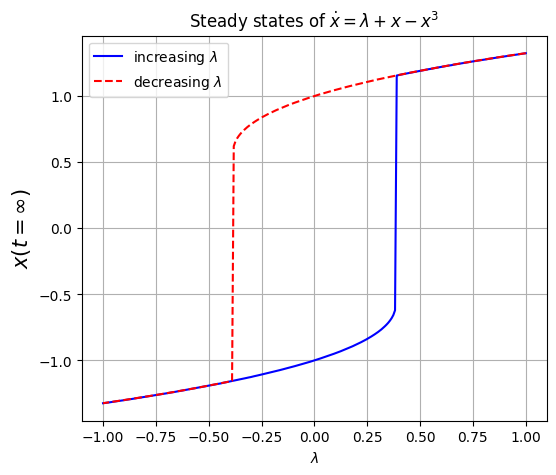

In [5]:
fig, ax = plt.subplots(1,1, figsize = (6,5))

ax.plot(lam_increase, x_increase, c='blue', label=r'increasing $\lambda$')
ax.plot(lam_decrease, x_decrease, c='red', linestyle="--", label=r'decreasing $\lambda$')
ax.grid(True)
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$x(t = \infty)$",size = 15)
ax.set_title("Steady states of "+r"$\dot{x} = \lambda + x - x^3$")
ax.legend()
plt.show()

# Stabnode learning

In [6]:
X = np.hstack((x_increase, x_decrease))
lam = np.hstack((lam_increase, lam_decrease))
repeat = 2

for _ in range(repeat):
    X = np.hstack((X,X))
    lam = np.hstack((lam, lam))

tau = torch.arange(0,len(lam),device=device)
t = (tau+1)*simulate_time[-1]

In [7]:
scaler = MinMaxScaler(feature_range=(-1,1))
X_scaled = scaler.fit_transform(X.reshape(-1,1))
X_scaled = torch.tensor(X_scaled,dtype=torch.float32, device=device)
scaler.data_max_, scaler.data_min_

(array([1.32443915]), array([-1.32455021]))

In [12]:
sample_rate = 5
tau_train = tau[::sample_rate]
X_train = X_scaled[tau_train]
lam_train = lam[tau_train]

In [13]:
tau_train.shape

torch.Size([400])

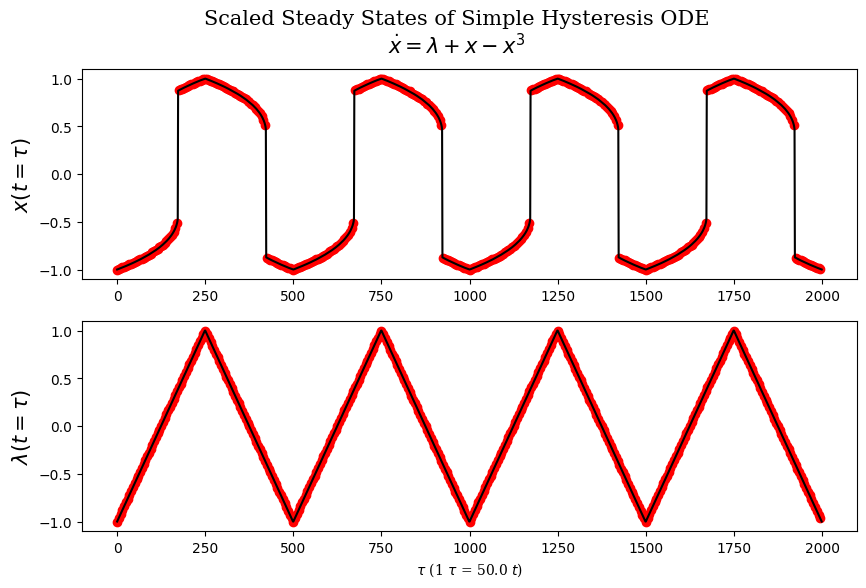

In [14]:
fig, ax = plt.subplots(2,1, figsize = (10,6))
color = 'black'

ax[0].plot(tau, X_scaled,c=color, label='True')
ax[0].scatter(tau_train, X_train,c='red', label='measurements')
ax[0].set_ylabel(r"$x(t = \tau)$",size=15, family='serif')

ax[1].plot(tau, lam,c=color)
ax[1].scatter(tau_train, lam_train,c='red')
ax[1].set_xlabel(fr"$\tau$ (1 $\tau$ = {simulate_time[-1]:.1f} $t$)",family='serif')
ax[1].set_ylabel(fr"$\lambda (t = \tau)$", family = 'serif', size=15)
plt.suptitle("Scaled Steady States of Simple Hysteresis ODE\n"+r"$\dot{x} = \lambda +x-x^3$",family='serif', size=15)
plt.show()

In [15]:
def lam_func(tau):
    idx = int(tau) % len(lam)
    return torch.tensor(lam[idx],dtype=torch.float32, device=device)

In [16]:
dim_in = X_train.shape[-1]
dim_out = X_train.shape[-1]
hidden_dim = 2

f = FTerm(dim_in, dim_out, hidden_dim )
g = GTerm(dim_in+1, dim_out, hidden_dim)

stab_node = StabNODE(f,g)
stab_node.to(device)

StabNODE(
  (f): FTerm(
    (network): Sequential(
      (0): Linear(in_features=1, out_features=2, bias=True)
      (1): Tanh()
      (2): Linear(in_features=2, out_features=1, bias=True)
      (3): Tanh()
    )
  )
  (g): GTerm(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=2, bias=True)
      (1): Tanh()
      (2): Linear(in_features=2, out_features=1, bias=True)
      (3): Tanh()
    )
  )
)

In [17]:
stab_node.f.args

{'dim_in': 1, 'dim_out': 1, 'hidden_dim': 2}

## Test model_trainer

In [18]:
from stabnode.node import model_trainer

In [19]:
loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr = 1e-2)
tau_span = tau_train.clone().detach().to(dtype=torch.float32, device=device)
x0 = X_train[0].reshape(-1, 1).clone().detach().to(dtype=torch.float32,device=device)
x0.requires_grad_(True)
n_epochs = 100

In [20]:
next(stab_node.parameters()).device.type

'cpu'

In [21]:
stab_node, log_history = model_trainer(stab_node,
              opt,loss_criteria,
              x0,
              tau_span,
              X_train,
              lam_func,
              n_epochs,
              min_improvement=1e-4,
              patience=10,
              print_every=10,
              solve_method='rk4',
              show_progress=True,
              save_path="results/test_model.pt"
)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0: Loss = 1.8152, time = 0.7041
Epoch 1: Loss = 1.5348, time = 0.6646
Epoch 2: Loss = 1.3188, time = 0.6685
Epoch 3: Loss = 1.1502, time = 0.6680
Epoch 4: Loss = 1.0193, time = 0.6729
Epoch 5: Loss = 0.9201, time = 0.6562
Epoch 10: Loss = 0.8197, time = 0.6935
Epoch 20: Loss = 0.7365, time = 0.6433
Epoch 30: Loss = 0.6000, time = 0.6745
Epoch 40: Loss = 0.4701, time = 0.6610
Epoch 50: Loss = 0.3780, time = 0.6614
Epoch 60: Loss = 0.3189, time = 0.6620
Epoch 70: Loss = 0.2820, time = 0.6594
Epoch 80: Loss = 0.2608, time = 0.7263
Epoch 90: Loss = 0.2495, time = 0.6585


dict_keys(['losses', 'times', 'stopping_criteria', 'best_model_epoch', 'method_failures', 'patience_hist'])


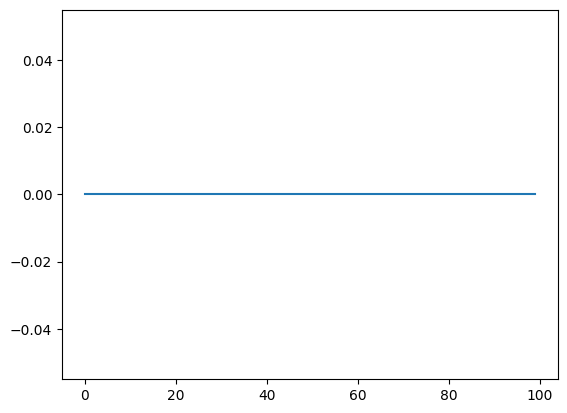

In [22]:
print(log_history.keys())
plt.plot(log_history["method_failures"])


In [23]:
from stabnode.node import _load_model_opt

model, opt, epoch, loss =_load_model_opt("results/test_model.pt")

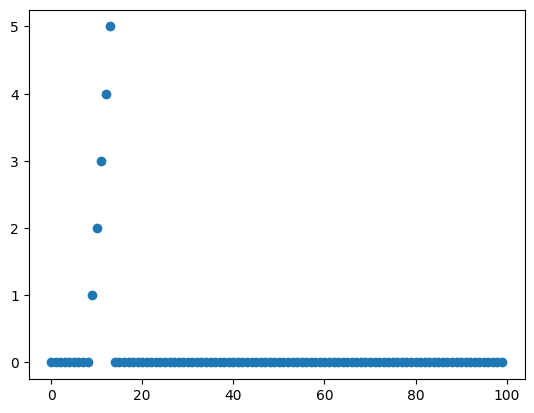

In [24]:
import pickle
with open("results/test_model_log.pkl", 'rb') as f:
    log_history_load = pickle.load(f)

plt.scatter(np.arange(len(log_history_load['patience_hist'])),log_history_load['patience_hist'])

In [ ]:
tau_span = tau_train.clone().detach().to(dtype=torch.float32, device=device)
x0 = X_train[0].reshape(-1, 1).clone().detach().to(dtype=torch.float32,device=device)
x0.requires_grad_(True)
print(x0)
method = 'rk4'
# method = None
x_pred = odeint(lambda t, x: stab_node(t,x,lam_func), x0, tau_span, method=method)

In [ ]:
if torch.isnan(x_pred).any():
    print("nan")

In [ ]:
loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr = 1e-2)

# early stopping criteria 
patience = ...
rtol = ...
print_every = 10

tau_span = tau_train.clone().detach().to(dtype=torch.float32, device=device)
x0 = X_train[0].reshape(-1, 1).clone().detach().to(dtype=torch.float32, device=device)
x0.requires_grad_(True)

n_epochs = 250
losses = []
opt_history = {}
# losses
# stop criteria - max-iterations, early-stop-atol
for epoch in tqdm(range(n_epochs)):
    t1 = time.time()
    opt.zero_grad()
    x_pred = odeint(lambda t, x: stab_node(t,x,lam_func), x0, tau_span, method='rk4')
    if torch.isnan(x_pred).any():
        print("Numerical instability. Using dopri15.")
        x_pred = odeint(lambda t, x: stab_node(t,x,lam_func), x0, tau_span, method=None)
    loss = loss_criteria(x_pred.squeeze(), X_train.squeeze())
    loss.backward()
    opt.step()
    t2 = time.time()
    losses.append(loss.item())
    if epoch <= 5 or epoch % print_every == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}, time = {t2-t1:.4f} s.")

# send modesl to cpu 
# save results
    

In [ ]:
# losses

In [ ]:
plt.plot(losses)
plt.yscale('log')
plt.show()

In [ ]:
losses = np.array(losses)

In [ ]:
losses[-10:]

In [ ]:
loss_diff = losses[1:] - losses[:-1]

In [ ]:
loss_diff[-50:].min()

In [ ]:
plt.plot(loss_diff[-20:])

# g and f outputs

In [ ]:
def g_true(x,lam):
    return (1/x)*((lam / x)  + 1)

def f_true(x):
    return -x**2

In [ ]:
g.eval()
f.eval()


g_true_out = []
g_pred_out = []

f_true_out = []
f_pred_out = []

for tau_i in tau:

    lam_i = lam_func(tau_i).reshape(-1,1)
    xi = X_scaled[tau_i].reshape(-1,1)
    xi_unscaled = X[tau_i].reshape(-1,1)

    g_true_out.append(g_true(xi_unscaled,lam_i.numpy()))
    f_true_out.append(f_true(xi_unscaled))

    with torch.no_grad():
        g_pred_out.append(g(xi,lam_i).detach().cpu().numpy())
        f_pred_out.append(f(xi).detach().cpu().numpy())

g_true_out = np.array(g_true_out).reshape(-1)
g_pred_out = np.array(g_pred_out).reshape(-1)

f_true_out = np.array(f_true_out).reshape(-1)
f_pred_out = np.array(f_pred_out).reshape(-1)
    

In [ ]:
finite_idx = np.isfinite(g_true_out)
np.count_nonzero(~finite_idx)

In [ ]:
g_true_scaled = scaler.transform(g_true_out[finite_idx].reshape(-1,1)).reshape(-1)

In [ ]:
g_pred_out[0], x0

In [ ]:
plt.plot(g_pred_out, linestyle='--', label='g node')
plt.plot(g_true_scaled, label='g true')
plt.scatter(tau_train, X_train)
# plt.plot(X_scaled, label='raw data')
plt.legend()
plt.show()

In [ ]:
x0, tau_train[0]

In [ ]:
X_scaled[:10]

In [ ]:
scaler.data_max_

In [ ]:
g_true_out.max()

In [ ]:
f_true_scaled = scaler.transform(f_true_out.reshape(-1,1)).reshape(-1)

In [ ]:
plt.plot(f_true_scaled,label='true')
plt.plot(f_pred_out, label='pred')
plt.legend()
plt.show()

In [ ]:
X_train[0].numpy()

In [ ]:
X_scaled[0]

# Check `train_model.py`

In [11]:
from train_model import main
from stabnode.node import _load_model_opt
import pickle
import matplotlib.pyplot as plt

In [2]:
main(seed=1234,sample_rate=5,lr=1e-2,n_epochs=11, hidden_dim=2,folder='results/test')

In [4]:
# Warning comes from loading with weights_only = False default.
# should seperate non state_dicts perhaps. But also it's probably fine.
model, opt, epoch, loss = _load_model_opt("results/test/seed_1234_sample_rate_5_lr_0.01_n_epochs_11_hidden_dim_2.pt")

/qfs/projects/atscale/atscale_dyn/Code/Ike/stable_node_control/stabnode/node.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  config = torch.load(save_path, map_locatio

In [9]:
log_path = "results/test/seed_1234_sample_rate_5_lr_0.01_n_epochs_11_hidden_dim_2_log.pkl"
with open(log_path, 'rb') as file:
    log_hist = pickle.load(file)

In [12]:
log_hist.keys()
losses = log_hist["losses"]

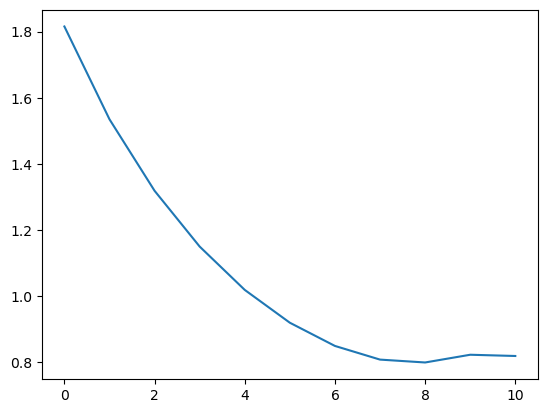

In [13]:
plt.plot(losses)
plt.show()